<a href="https://colab.research.google.com/github/ruturajkanake/retention-modelling-analysis/blob/master/Retention_Modelling_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = pd.read_excel('RetensionModellingDataset.xlsx')

In [4]:
dataset.head()

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,...,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1,HS,4.0,4.0,CA,0.0,1.0,A,2011-01-14,2011-01-14,...,K,Elementary,K->Elementary,H,1.0,0.063646,0.936508,4.0,L,1.0
1,2,HC,8.0,8.0,AZ,0.0,7.0,A,2011-01-14,2011-01-21,...,Middle,Middle,Middle->Middle,H,1.0,0.025882,0.880000,3.0,L,1.0
2,3,HD,8.0,8.0,FL,0.0,3.0,A,2011-01-15,2011-01-17,...,Middle,Middle,Middle->Middle,H,1.0,0.025131,0.888889,3.0,L,1.0
3,4,HN,9.0,12.0,VA,1.0,3.0,B,2011-01-15,2011-01-17,...,Undefined,Undefined,Undefined->Undefined,H,0.0,NaN,1.000000,0.0,NaN,0.0
4,5,HD,6.0,8.0,FL,0.0,6.0,T,2011-01-16,2011-01-21,...,Middle,Middle,Middle->Middle,H,0.0,0.112500,0.910112,8.0,M-L,0.0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              2390 non-null   object        
 1   Program.Code                    2389 non-null   object        
 2   From.Grade                      2262 non-null   float64       
 3   To.Grade                        2239 non-null   float64       
 4   Group.State                     2389 non-null   object        
 5   Is.Non.Annual.                  2389 non-null   float64       
 6   Days                            2389 non-null   float64       
 7   Travel.Type                     2389 non-null   object        
 8   Departure.Date                  2389 non-null   datetime64[ns]
 9   Return.Date                     2389 non-null   datetime64[ns]
 10  Deposit.Date                    2389 non-null   datetime64[ns]
 11  Spec

In [6]:
dataset.isnull().sum(axis=0)

ID                                   2
Program.Code                         3
From.Grade                         130
To.Grade                           153
Group.State                          3
Is.Non.Annual.                       3
Days                                 3
Travel.Type                          3
Departure.Date                       3
Return.Date                          3
Deposit.Date                         3
Special.Pay                       1922
Tuition                              3
FRP.Active                           3
FRP.Cancelled                        3
FRP.Take.up.percent.                 3
Early.RPL                          676
Latest.RPL                          22
Cancelled.Pax                        3
Total.Discount.Pax                   3
Initial.System.Date                 11
Poverty.Code                       602
Region                               3
CRM.Segment                          7
School.Type                          3
Parent.Meeting.Flag      

### **Data Preprocessing**

In [7]:
retain = len(dataset[dataset['Retained.in.2012.'] == 1.0])/len(dataset)*100
no_retain = len(dataset[dataset['Retained.in.2012.'] == 0.0])/len(dataset)*100
retain_percentage = [retain,no_retain]

Text(0.5, 1.0, 'RETAIN PERCENTAGE')

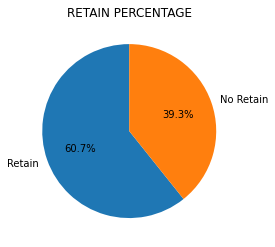

In [8]:
plt.pie(retain_percentage,labels = ['Retain','No Retain'],autopct='%1.1f%%',startangle = 90,)
plt.title('RETAIN PERCENTAGE')

In [9]:
def bar_chart(feature):
    retain = dataset[dataset['Retained.in.2012.']==1.0][feature].value_counts()
    not_retain = dataset[dataset['Retained.in.2012.']==0.0][feature].value_counts()
    df = pd.DataFrame([retain, not_retain])
    df.index = ['Retain','Not Retain']
    df.plot(kind='bar',stacked=True, figsize=(10,5), title=feature)

In [10]:
dataset = dataset.drop(['ID', 'From.Grade', 'To.Grade', 'Special.Pay', 'Deposit.Date', 'Initial.System.Date', 'Departure.Date', 'Return.Date', 'Early.RPL', 'Latest.RPL', 'Poverty.Code', 'FirstMeeting', 'LastMeeting', 'DifferenceTraveltoFirstMeeting', 'DifferenceTraveltoLastMeeting', 'FPP.to.School.enrollment', 'SchoolSizeIndicator', 'Total.School.Enrollment', 'Group.State'], 1);

In [11]:
object_columns = dataset.select_dtypes(include='object').columns

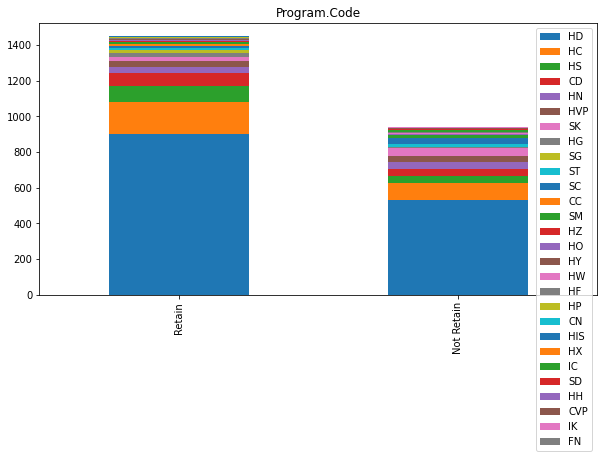

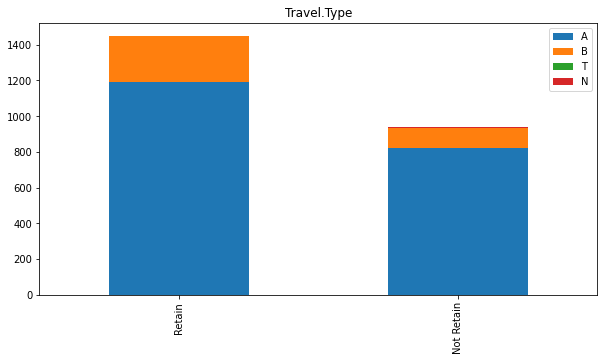

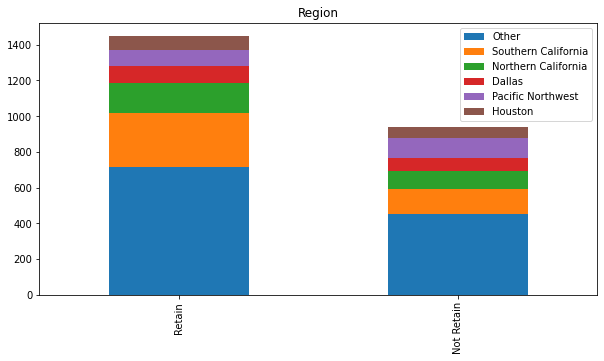

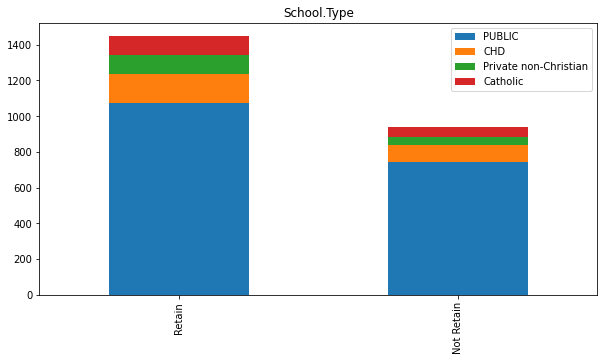

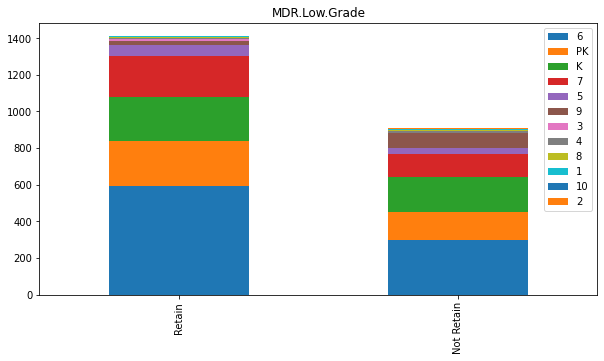

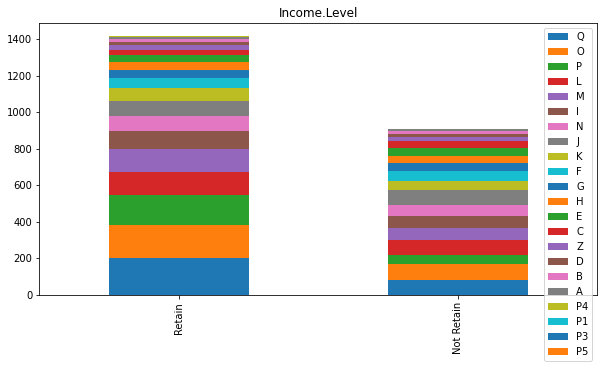

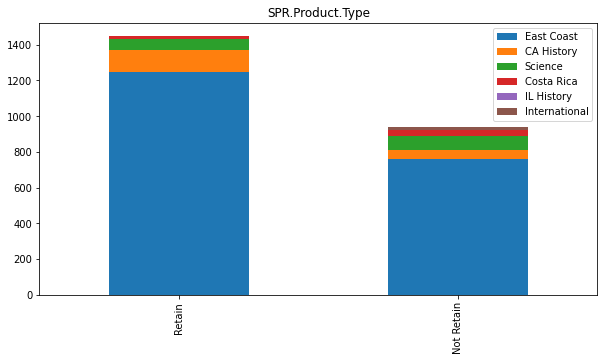

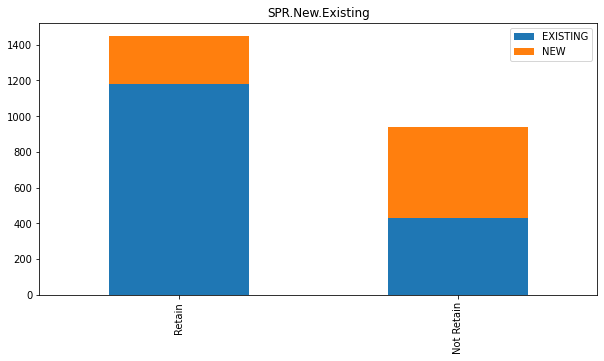

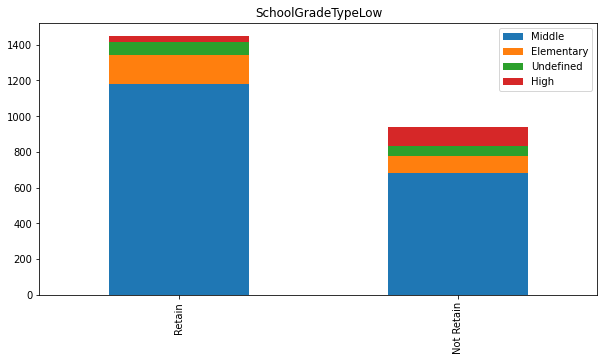

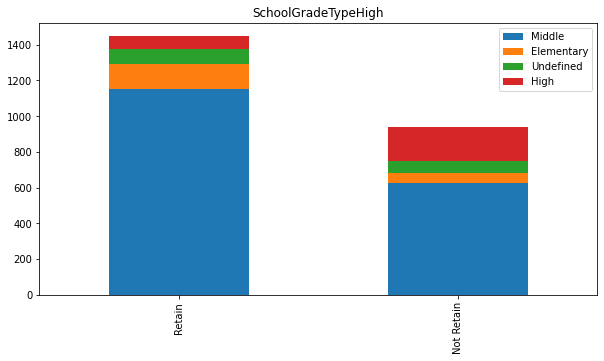

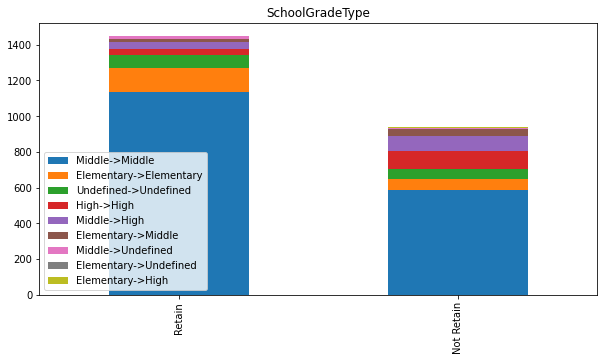

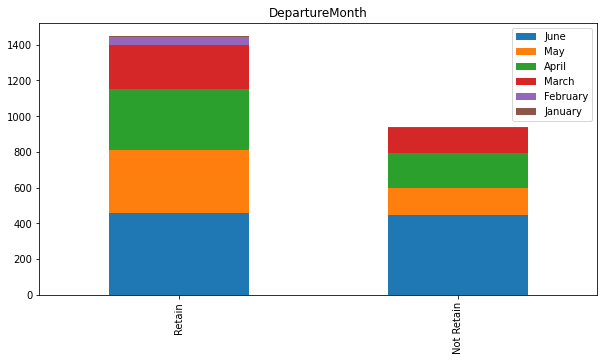

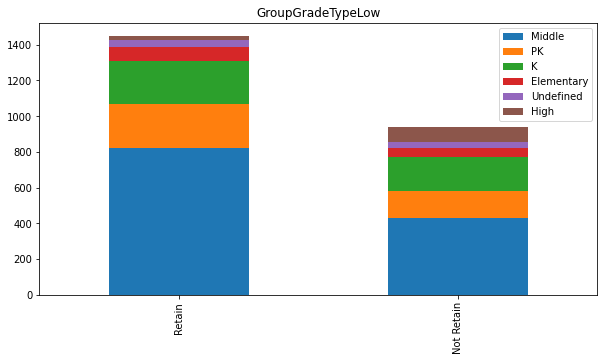

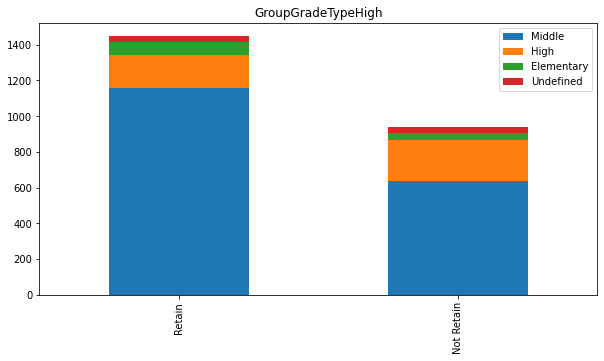

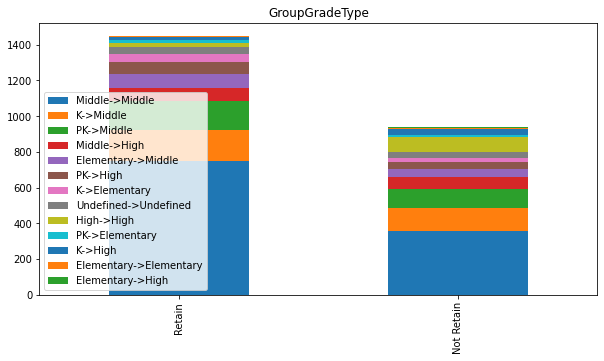

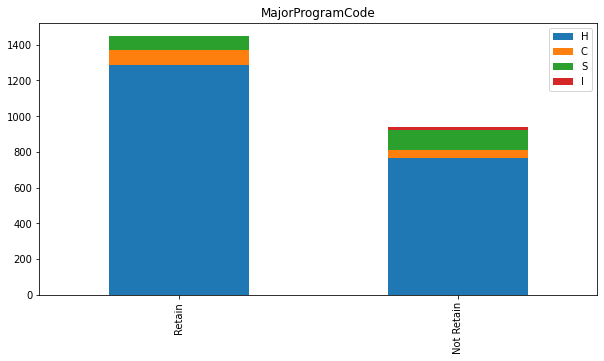

In [12]:
for col in object_columns:
  bar_chart(col)

In [13]:
for col in object_columns:
  dataset[col] = dataset.groupby(col).ngroup()

In [14]:
dataset.fillna(dataset.mean().round(1), inplace=True)

In [15]:
float_columns = dataset.select_dtypes(include='float64').columns

In [16]:
for col in filter(lambda col: col not in ['FRP.Take.up.percent.', 'EZ.Pay.Take.Up.Rate', 'FPP.to.PAX'], float_columns):
  dataset[col] = dataset[col].astype('int64')

### **Train Test Split**

In [17]:
x = dataset.iloc[: , 1:36].values
y = dataset.iloc[:, 36].values

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state = 0)

### **Feature Scaling**

In [19]:
sc_x = StandardScaler()
xtrain = sc_x.fit_transform(xtrain)
xtest = sc_x.transform(xtest)

In [20]:
print("Standardised Training Set : \n", xtrain[0])

Standardised Training Set : 
 [-0.43381881 -0.39250484 -0.42007759  0.25696967 -0.5825616   0.17644444
 -0.31370243 -0.18291012 -0.33751363  0.00464425  1.10394004  0.30996566
  0.40450625 -0.65294914 -0.21500279 -1.28158595  0.5070121  -0.33304285
 -0.0363426   1.41534394 -0.592068   -0.57611172  0.25696967 -0.16665855
  0.31608046  0.30842125  0.34922053  1.21284536  0.20048485  0.41261698
  0.21413192 -0.18929498 -1.10536649 -0.51076452 -0.33751363]


In [21]:
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_classifier.fit(xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', random_state=0)

### **Comparing different classification models**

#### **Decision Tree Classifier**

In [22]:
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_classifier.fit(xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [23]:
# Predicting 
y_pred_decision_tree = dt_classifier.predict(xtest)

In [24]:
cm_decision = confusion_matrix(ytest, y_pred_decision_tree)
print("confusion Marix : \n", cm_decision)

confusion Marix : 
 [[103  76]
 [ 64 236]]


In [25]:
Accuracy_Decison = ((cm_decision[0][0] + cm_decision[1][1]) / cm_decision.sum()) *100
print("Accuracy  : ", Accuracy_Decison)

# Precision = TP / (TP + FP)
Precision_Decision = (cm_decision[0][0] / ( cm_decision[0][0] + cm_decision[0][1] ))
print("Precision : ", Precision_Decision)

# Recall = TP / (TP + FN)
Recall_Decision = (cm_decision[0][0] / (cm_decision[0][0] + cm_decision[1][0]))
print("Recall    : ", Recall_Decision)

# F1 Score = 2*(P * R) / (P + R)
F1_Score_Decision = 2 * (Precision_Decision * Recall_Decision) / (Precision_Decision + Recall_Decision)
print("F1 Score  : ", F1_Score_Decision)

Accuracy  :  70.77244258872652
Precision :  0.5754189944134078
Recall    :  0.6167664670658682
F1 Score  :  0.5953757225433527


#### **Support Vector Machine**

In [26]:
svc_classifier = SVC(kernel = 'linear', random_state =0)
svc_classifier.fit(xtrain, ytrain)

SVC(kernel='linear', random_state=0)

In [27]:
# Predicting
y_pred2 = svc_classifier.predict(xtest)

In [28]:
cm_svc = confusion_matrix(ytest, y_pred2)
print("Confusion Matrix : \n\n", cm_svc)

Confusion Matrix : 

 [[127  52]
 [ 59 241]]


In [29]:
Accuracy_SVC = ((cm_svc[0][0] + cm_svc[1][1]) / cm_svc.sum()) *100
print("Accuracy  : ", Accuracy_SVC)

# Precision = TP / (TP + FP)
Precision_SVC = (cm_svc[0][0] / ( cm_svc[0][0] + cm_svc[0][1] ))
print("Precision : ", Precision_SVC)

# Recall = TP / (TP + FN)
Recall_SVC = (cm_svc[0][0] / (cm_svc[0][0] + cm_svc[1][0]))
print("Recall    : ", Recall_SVC)

# F1 Score = 2*(P * R) / (P + R)
F1_Score_SVC = 2 * (Precision_SVC * Recall_SVC) / (Precision_SVC + Recall_SVC)
print("F1 Score  : ", F1_Score_SVC)

Accuracy  :  76.82672233820459
Precision :  0.7094972067039106
Recall    :  0.6827956989247311
F1 Score  :  0.6958904109589041


#### **Random Forest Classifier**

In [30]:
rf_classifier = RandomForestClassifier(random_state=0)

In [31]:
rf_classifier.fit(xtrain, ytrain)

RandomForestClassifier(random_state=0)

In [32]:
# Predicting
y_pred3 = rf_classifier.predict(xtest)

In [33]:
cm_rf = confusion_matrix(ytest, y_pred3)
print("Confusion Matrix : \n\n", cm_rf)

Confusion Matrix : 

 [[118  61]
 [ 50 250]]


In [34]:
Accuracy_RF = ((cm_rf[0][0] + cm_rf[1][1]) / cm_rf.sum()) *100
print("Accuracy  : ", Accuracy_RF)

# Precision = TP / (TP + FP)
Precision_RF = (cm_rf[0][0] / ( cm_rf[0][0] + cm_rf[0][1] ))
print("Precision : ", Precision_RF)

# Recall = TP / (TP + FN)
Recall_RF = (cm_rf[0][0] / (cm_rf[0][0] + cm_rf[1][0]))
print("Recall    : ", Recall_RF)

# F1 Score = 2*(P * R) / (P + R)
F1_Score_RF = 2 * (Precision_RF * Recall_RF) / (Precision_RF + Recall_RF)
print("F1 Score  : ", F1_Score_RF)

Accuracy  :  76.82672233820459
Precision :  0.659217877094972
Recall    :  0.7023809523809523
F1 Score  :  0.6801152737752162


#### **K Nearest Neighbours**

In [35]:
knn_classifier = KNeighborsClassifier()

In [36]:
knn_classifier.fit(xtrain, ytrain)

KNeighborsClassifier()

In [37]:
# Predicting
y_pred4 = knn_classifier.predict(xtest)

In [38]:
cm_knn = confusion_matrix(ytest, y_pred4)
print("Confusion Matrix : \n\n", cm_knn)

Confusion Matrix : 

 [[105  74]
 [ 54 246]]


In [39]:
Accuracy_kNN = ((cm_knn[0][0] + cm_knn[1][1]) / cm_knn.sum()) *100
print("Accuracy  : ", Accuracy_kNN)

# Precision = TP / (TP + FP)
Precision_kNN = (cm_knn[0][0] / ( cm_knn[0][0] + cm_knn[0][1] ))
print("Precision : ", Precision_kNN)

# Recall = TP / (TP + FN)
Recall_kNN = (cm_knn[0][0] / (cm_knn[0][0] + cm_knn[1][0]))
print("Recall    : ", Recall_kNN)

# F1 Score = 2*(P * R) / (P + R)
F1_Score_kNN = 2 * (Precision_kNN * Recall_kNN) / (Precision_kNN + Recall_kNN)
print("F1 Score  : ", F1_Score_kNN)

Accuracy  :  73.2776617954071
Precision :  0.5865921787709497
Recall    :  0.660377358490566
F1 Score  :  0.621301775147929


### **Comparing Accuracy**
Decision Tree Classifier  : 70.77 <br>
Support Vector Machine    : 76.82 <br>
Random Forest Classifier  : 76.82 <br>
K Nearest Neighbours      : 73.28 